## 데이터 준비

- 라이브러리 불러오기 & matplotlib 한글 출력 설정

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

- 분석할 데이터 로드

In [2]:
origin_data = pd.read_csv("subway_time.csv")

- 전처리(타입 변경, 불필요한 행/열 제거), 유동인구로 재구성, 문제 1번 데이터, 2번 기초 데이터 생성

In [3]:
moved_temp = origin_data.iloc[1:, :].copy()
moved_data, moved_data_sum, moved_temp1 = moved_temp.iloc[:,:2].copy(), moved_temp.iloc[:,:2].copy(), moved_temp.iloc[:,2:].copy()
moved_temp1 = moved_temp1.astype(dtype=np.int64)

moved_data_sum["유동인구"]=0

for i in range(0,len(moved_temp1.columns),2):
    temp = moved_temp1.iloc[:,i]+moved_temp1.iloc[:,i+1]
    moved_data = pd.concat([moved_data, temp], axis=1)
    moved_data_sum["유동인구"] += temp
    
moved_data.columns=["호선명", "지하철역"]+[i for i in moved_temp1.columns if "~" in i]

## 1번 풀이

- 노선 선택, 없을 시 예외

In [4]:
def choose_line(line, data):
    lines = set(data["호선명"])
    if line not in lines:
        raise Exception("해당 노선 없음")
    return data.loc[data["호선명"]==line, :]

- 데이터 원형그래프로 시각화

In [5]:
def draw_pie(data):
    plt.figure(figsize=(8,8))
    plt.title(data.iloc[0,0])
    plt.pie(x = data["유동인구"], labels = data["지하철역"], autopct="%.2f%%")
    plt.show()

In [6]:
def promft():
    print("호선 목록 : ")
    for i in sorted(set(moved_data_sum["호선명"])):
        print(i, end=', ')
    print()

In [7]:
def p1():
    promft()
    while True:
        try:
            line=input("유동인구 비율을 알고싶은 호선을 입력하세요  >>  ")
            draw_pie(choose_line(line, moved_data_sum))
        except Exception as e:
            print(e)
        else:
            return

### 1번 정답

호선 목록 : 
1호선, 2호선, 3호선, 4호선, 5호선, 6호선, 7호선, 8호선, 9호선, 9호선2~3단계, 경강선, 경부선, 경원선, 경의선, 경인선, 경춘선, 공항철도 1호선, 과천선, 분당선, 서해선, 수인선, 신림선, 안산선, 우이신설선, 일산선, 장항선, 중앙선, 
유동인구 비율을 알고싶은 호선을 입력하세요  >>  장항선


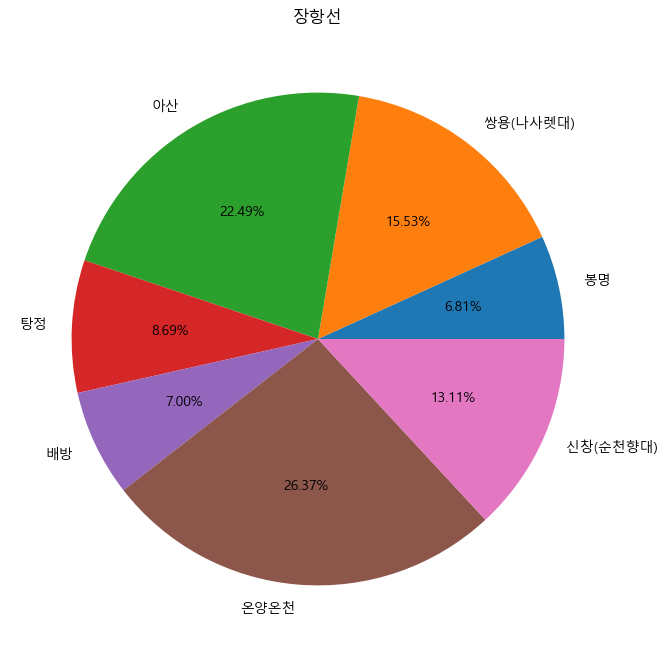

In [8]:
p1()

## 2번 풀이

- 비율로 재구성

In [9]:
p2_data = moved_data.copy()
for i in p2_data.columns[2:]:
    p2_data[i] /= moved_data_sum["유동인구"]

- 기준이 되는 역의 비율 뽑기

In [10]:
def station_mask(line, station):
    test = p2_data.loc[(p2_data["호선명"] == line) & (p2_data["지하철역"] == station), "04:00:00~04:59:59":]
    return test.values.reshape(-1)

- 위의 기준에 따라 모든 역의 mse계산, 상위 5개역 도출

In [11]:
def find_sim_num(series):
    temp = p2_data.iloc[:, 2:].copy()
    temp = temp.values
    temp = (temp-series)**2
    temp = np.sum(temp, axis=1)
    temp = np.argsort(temp)
    return temp[:6]

- 상위 5개역 비율 시각화

In [12]:
def draw_plot(arr):
    plt.figure(figsize=(14,7))
    plt.title(f'{p2_data.iloc[arr[0],0]} {p2_data.iloc[arr[0],1]}(역) 와(과) 유동인구 비율이 비슷한 지하철 역 상위 5개')
    for i in arr:
        plt.plot(p2_data.iloc[i,2:], label = f'{p2_data.iloc[i,0]} {p2_data.iloc[i,1]}')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

- 역과 (환승역이면) 노선 고르기

In [13]:
def p2_choose_station(station):
    stations = set(p2_data["지하철역"])
    if station not in stations:
        raise Exception("역 없음")
    lines = set(p2_data.loc[p2_data["지하철역"]==station, "호선명"])
    return sorted(lines)

In [14]:
def p2_choose_line(lines):
    if len(lines)==1:
        return lines[0]
    line = input(f'알고자 하는 노선을 선택하세요 {lines}:  ')
    if line not in lines:
        raise Exception("노선 없음")
    return line

In [15]:
def p2():
    print("역 입력 예시 : 광운대(0), 광운대역(X)")
    while True:
        try:
            station = input("비슷한 유동인구 비율을 알고 싶은 역을 입력하세요:  ") 
            line = p2_choose_line(p2_choose_station(station))
            draw_plot(find_sim_num(station_mask(line, station)))
        except Exception as e:
            print(e)
        else:
            return

### 2번 정답

역 입력 예시 : 광운대(0), 광운대역(X)
비슷한 유동인구 비율을 알고 싶은 역을 입력하세요:  제기동


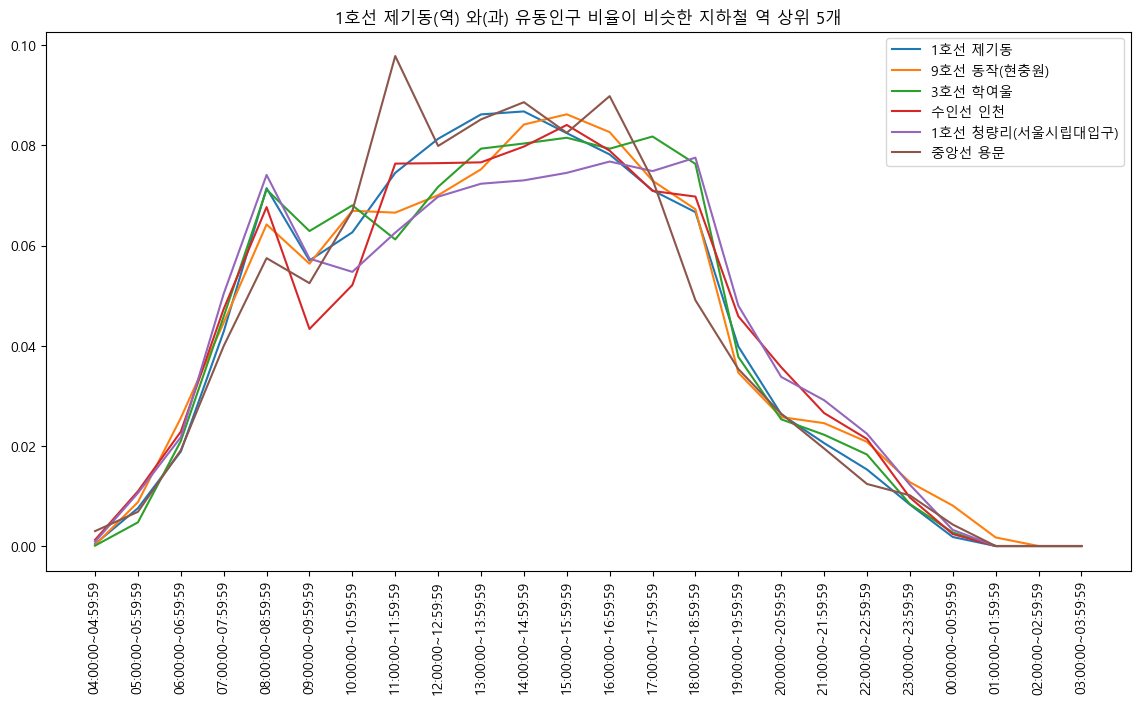

In [23]:
p2()

## 3번 풀이

- 출근, 퇴근시간 위치 정의(슬라이싱 위함)

In [17]:
time = [i for i in moved_temp1.columns]
drhs, drhe = time.index("06:00:00~06:59:59"), time.index("10:00:00~10:59:59")
nrhs, nrhe = time.index("17:00:00~17:59:59"), time.index("21:00:00~21:59:59")

- 비율 정보 계산 및 데이터에 추가

In [18]:
p3_data=moved_data.iloc[:, 1].copy()
p3_temp = pd.DataFrame(data= np.zeros((len(p3_data.index), 6), dtype=np.int64),
                       columns=["출근 승차", "출근 하차", "퇴근 승차", "퇴근 하차", "전체 승차", "전체 하차"],
                       index=[i for i in range(1,len(p3_data.index)+1)])

for i in moved_temp1.columns:
    if "~" in i:
        p3_temp["전체 승차"] += moved_temp1.loc[: , i]
    else:
        p3_temp["전체 하차"] += moved_temp1.loc[: , i]
        
for i in range(drhs, drhe):
    if "~" in time[i]:
        p3_temp["출근 승차"] += moved_temp1.iloc[: , i]
    else:
        p3_temp["출근 하차"] += moved_temp1.iloc[: , i]

for i in range(nrhs, nrhe):
    if "~" in time[i]:
        p3_temp["퇴근 승차"] += moved_temp1.iloc[: , i]
    else:
        p3_temp["퇴근 하차"] += moved_temp1.iloc[: , i]

p3_data=pd.concat([p3_data,p3_temp], axis=1)

- 환승역의 중복 합치기

In [19]:
p3_data = p3_data.groupby("지하철역").sum()

- 지표 계산 및 열에 추가

In [20]:
p3_data["출근승차/전체승차"] = p3_data["출근 승차"] / p3_data["전체 승차"]
p3_data["퇴근하차/전체하차"] = p3_data["퇴근 하차"] / p3_data["전체 하차"]
p3_data["베드타운 지표"] = (p3_data["출근승차/전체승차"] + p3_data["퇴근하차/전체하차"]) / 2

p3_data["출근하차/전체하차"] = p3_data["출근 하차"] / p3_data["전체 하차"]
p3_data["퇴근승차/전체승차"] = p3_data["퇴근 승차"] / p3_data["전체 승차"]
p3_data["기업단지 지표"] = (p3_data["출근하차/전체하차"] + p3_data["퇴근승차/전체승차"]) / 2

In [24]:
def p3():
    print("베드타운 (목록&비율)")
    print(p3_data.nlargest(3,"베드타운 지표")["베드타운 지표"])
    print()
    print("기업단지 (목록&비율)")
    print(p3_data.nlargest(3,"기업단지 지표")["기업단지 지표"])

### 3번 정답

In [25]:
p3()

베드타운 (목록&비율)
지하철역
삼동    0.518713
강매    0.516872
계양    0.514441
Name: 베드타운 지표, dtype: float64

기업단지 (목록&비율)
지하철역
남동인더스파크    0.640829
가산디지털단지    0.598023
공항화물청사     0.573389
Name: 기업단지 지표, dtype: float64
